Download data in https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [90]:
# Import libs
import torch 
import numpy as np
import matplotlib.pyplot as plt
import os 
from torchvision import transforms as T, datasets
from torch import  nn
import torch.nn.functional as F 
import timm

In [91]:
torch.__version__

'1.8.1'

In [92]:
class Config:
    epochs = 5
    lr = 0.001 
    batch_size = 16
    
    #model import from timm 
    model_name = "tf_efficientnet_b4_ns"
    img_size = 224 
    
    data_dir = "chest_xray"
    test = "test"
    train = "train"
    val = "val"
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
#Enable GPU    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We have : {}".format(device))

We have : cuda


Image transformation and load Dataset

In [129]:
class_name = ['NORMAL','PNEUMONIA']
class Utils:
    def show_image_orignal(image, label, get_denormalize=True):
        class_name = ['NORMAL','PNEUMONIA']
        image = image.permute(1, 2, 0)
        mean = torch.FloatTensor([0.485, 0.456, 0.406])
        std = torch.FloatTensor([0.229, 0.224, 0.225])
        
        if get_denormalize == True:
            image = image * std + mean
            image = np.clip(image, 0, 1)
            plt.title(class_name[label])
            plt.imshow(image)
            plt.show()
        else:
            plt.title(class_name[label])
            plt.imshow(image)
            plt.show()

    def show_grid(image,title = None ):
        image = image.permute(1,2,0)
        mean = torch.FloatTensor([0.485, 0.456, 0.406])
        std = torch.FloatTensor([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image,0,1)
        
        plt.figure(figsize=[15, 15])
        plt.imshow(image)
        if title != None:
            plt.title(title) 


    def view_classify(image,ps,label):
    
        class_name = ['NORMAL','PNEUMONIA']
        classes = np.array(class_name)

        ps = ps.cpu().data.numpy().squeeze()
        
        image = image.permute(1,2,0)
        mean = torch.FloatTensor([0.485, 0.456, 0.406])
        std = torch.FloatTensor([0.229, 0.224, 0.225])
        
    
        image = image*std + mean
        img = np.clip(image,0,1)
    
        fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
        ax1.imshow(img)
        ax1.set_title('Ground Truth : {}'.format(class_name[label]))
        ax1.axis('off')
        ax2.barh(classes, ps)
        ax2.set_aspect(0.1)
        ax2.set_yticks(classes)
        ax2.set_yticklabels(classes)
        ax2.set_title('Predicted Class')
        ax2.set_xlim(0, 1.1)

        plt.tight_layout()

        return None                   

In [94]:
train_transform = T.Compose([
    T.Resize(size = (Config.img_size, Config.img_size)),
    T.RandomRotation(degrees = (-30, +30)),
    T.ToTensor(), # (w,h,c) -> (c,h,w)
    T.Normalize(Config.mean, Config.std)
])

val_transform = T.Compose([
    T.Resize(size = (Config.img_size, Config.img_size)),
    T.ToTensor(), # (w,h,c) -> (c,h,w)
    T.Normalize(Config.mean, Config.std)
])

test_transform = T.Compose([
    T.Resize(size = (Config.img_size, Config.img_size)),
    T.ToTensor(), # (w,h,c) -> (c,h,w)
    T.Normalize(Config.mean, Config.std)
])

In [95]:
# train,val,test path

train_path = os.path.join(Config.data_dir, Config.train)
val_path = os.path.join(Config.data_dir, Config.val)
test_path = os.path.join(Config.data_dir, Config.test)

In [96]:
# train,val,test set

trainset = datasets.ImageFolder(train_path, transform = train_transform)
valset = datasets.ImageFolder(val_path, transform = val_transform)
testset = datasets.ImageFolder(test_path, transform = test_transform)

print("Length of trainset : {}".format(len(trainset)))
print("Length of valset : {}".format(len(valset)))
print("Length of testset : {}".format(len(testset)))


Length of trainset : 5216
Length of valset : 16
Length of testset : 624


{'NORMAL': 0, 'PNEUMONIA': 1}


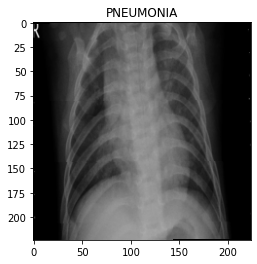

In [97]:
image, label = trainset[5000]
print(trainset.class_to_idx)
Utils.show_image_orignal(image, label)

In [98]:
#Load dataset into Batches 
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


In [99]:
train_dataloader = DataLoader(trainset, batch_size=Config.batch_size, shuffle= True)
val_dataloader = DataLoader(valset, batch_size=Config.batch_size, shuffle= True)
test_dataloader = DataLoader(testset, batch_size=Config.batch_size, shuffle= True)


In [100]:
print("Length of trainloader : {}".format(len(train_dataloader)))
print("Length of valloader : {}".format(len(val_dataloader)))
print("Length of testloader : {}".format(len(test_dataloader)))

Length of trainloader : 326
Length of valloader : 1
Length of testloader : 39


In [101]:
# dataiter = iter(train_dataloader)
# images, labels = dataiter.next()

# out = make_grid(images, nrow= 4)
# Utils.show_grid(out, title= [class_name[x] for x in labels])

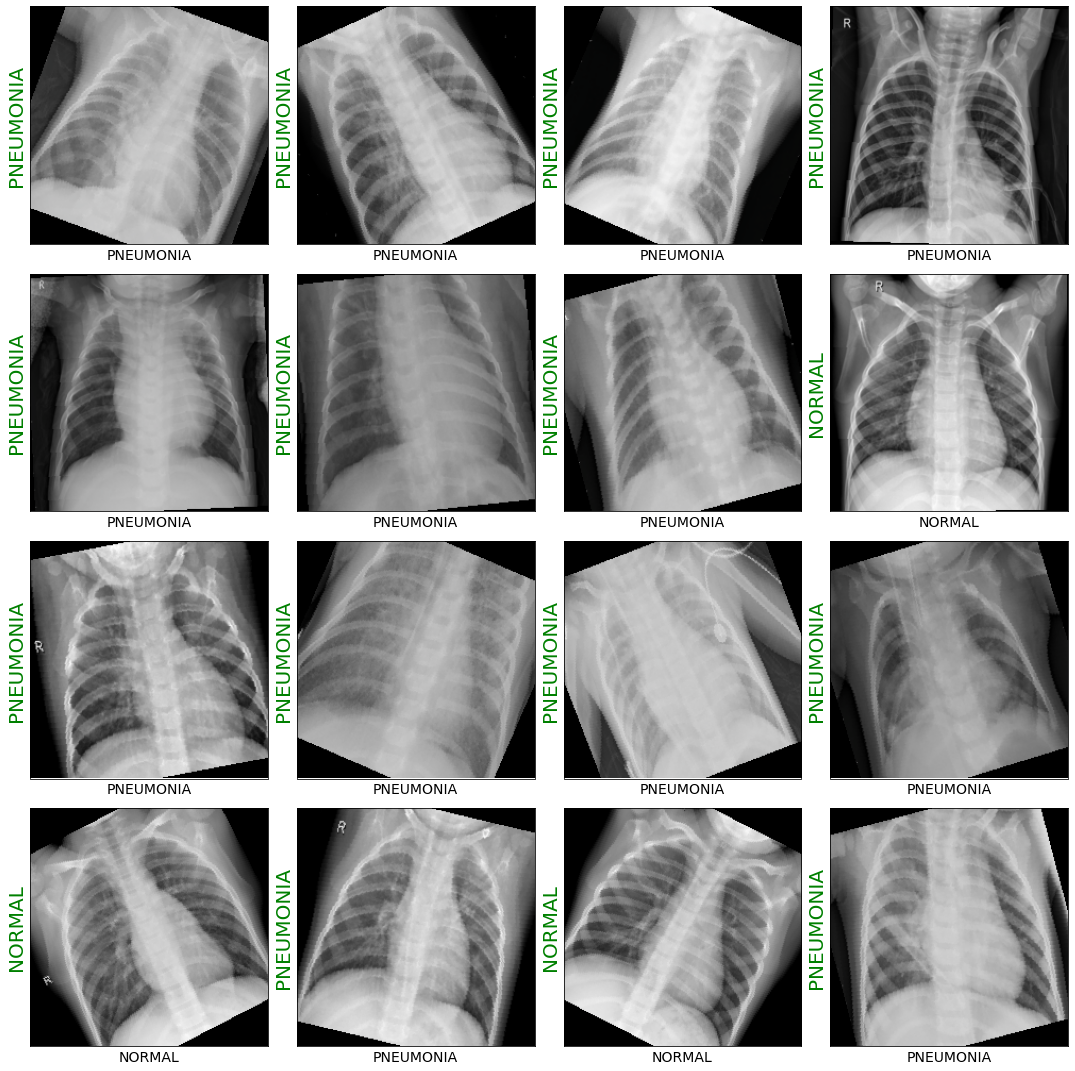

In [178]:
def show_images(images, labels, preds):
    plt.figure(figsize=(15,15))
    for i, image in enumerate(images):
        plt.subplot(4,4,i + 1,xticks=[],yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229,0.224, 0.225])
        image = image * std + mean
        image = np.clip(image,0.,1.)
        plt.imshow(image)
        
        color ='green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_name[int(labels[i].numpy())]}',fontsize=14)
        plt.ylabel(f'{class_name[int(preds[i].numpy())]}', color = color, loc='center', fontsize=20)
    plt.tight_layout()
    plt.show()
images, labels = next(iter(train_dataloader))
show_images(images, labels, labels)

In [103]:
#Fine Tuning Efficient Model 
!pip install timm

In [104]:
model = timm.create_model(Config.model_name, pretrained = True)
model
for param in model.parameters():
    param.requires_grad = False
# Custom just change classifier and put output before features and train it
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2)
)    
model.classifier = nn.Linear(in_features = 1792, out_features =2 )

In [105]:
from torchsummary import  summary
#move model to device
model.to(device)
summary(model, input_size = (3,Config.img_size, Config.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
    SqueezeExcite-10         [-1, 48, 112, 112]               0
           Conv2d-11         [-1, 24, 112, 112]           1,152
      BatchNorm2d-12         [-1, 24, 112, 112]              48
         Identity-13         [-1, 24, 112, 112]               0
DepthwiseSeparableConv-14         [-1, 

In [106]:
# Build a Simple Trainer
from tqdm import tqdm
# use support cuda for training
torch.backends.cudnn.benchmark = True


In [107]:
def accuracy(y_pred,labels):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1) 
    equals = top_class == labels.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [108]:
class PneumoniaTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                print("="*30)
                torch.save(model.state_dict(),'PneumonialModel.pt')
                valid_min_loss = avg_valid_loss # reset

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [109]:
#loss
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = Config.lr)
#schedular 
schedular = None
print("-----Start training-----")
trainer = PneumoniaTrainer(criterion,optimizer, schedular)
trainer.fit(model,train_dataloader,val_dataloader,epochs = Config.epochs)

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
Valid_loss decreased inf --> 0.7115985155105591
  0%|          | 0/326 [00:00<?, ?it/s]Epoch : 1 Train Loss : 0.326181 Train Acc : 0.863114
Epoch : 1 Valid Loss : 0.711599 Valid Acc : 0.562500
100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
Valid_loss decreased 0.7115985155105591 --> 0.6853098273277283
  0%|          | 0/326 [00:00<?, ?it/s]Epoch : 2 Train Loss : 0.238464 Train Acc : 0.902799
Epoch : 2 Valid Loss : 0.685310 Valid Acc : 0.562500
  0%|          | 0/326 [00:00<?, ?it/s]Epoch : 3 Train Loss : 0.218088 Train Acc : 0.913152
Epoch : 3 Valid Loss : 0.750520 Valid Acc : 0.500000
  0%|          | 0/326 [00:00<?, ?it/s]Epoch : 4 Train Loss : 0.209711 Train Acc : 0.917178
Epoch : 4 Valid Loss : 0.759509 Valid Acc : 0.500000
100%|██████████| 1/1 [00:00<00:00,  1.54it/s]Epoch : 5 Train Loss : 0.205281 Train Acc : 0.918136
Epoch : 5 Valid Loss : 0.762286 Valid Acc : 0.437500



In [110]:
#load model trained
model.load_state_dict(torch.load('PneumonialModel.pt', map_location= device))
model.eval() # this turns off the dropout lapyer and batch norm

avg_test_loss, avg_test_acc= trainer.valid_batch_loop(model, test_dataloader)

print("Test Acc : {}".format(avg_test_acc))
print("Test Loss : {}".format(avg_test_loss))

100%|██████████| 39/39 [00:23<00:00,  1.64it/s]Test Acc : 0.8509615659713745
Test Loss : 0.36408910384544957



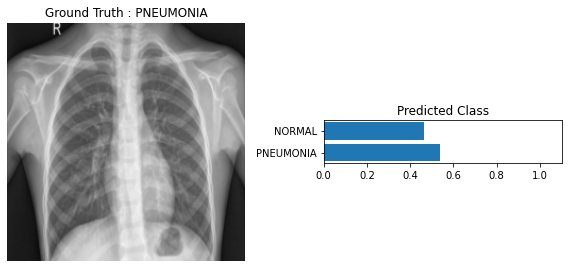

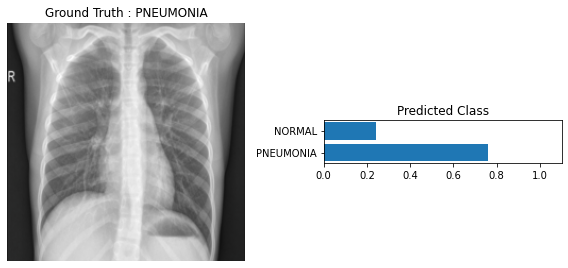

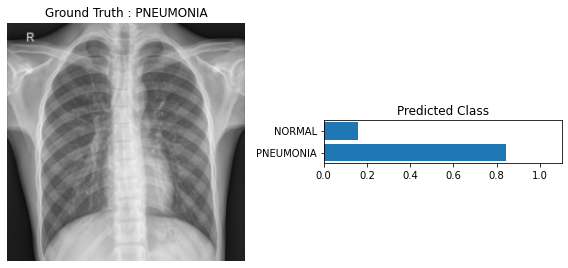

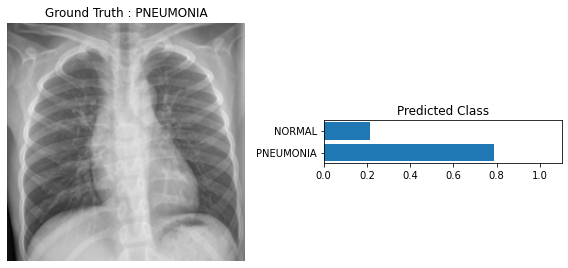

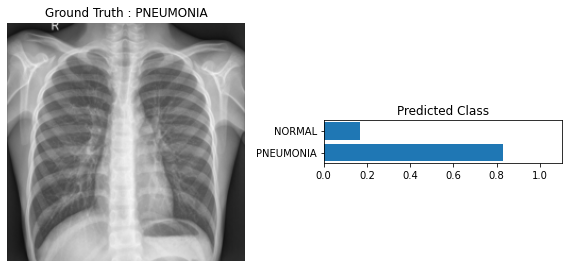

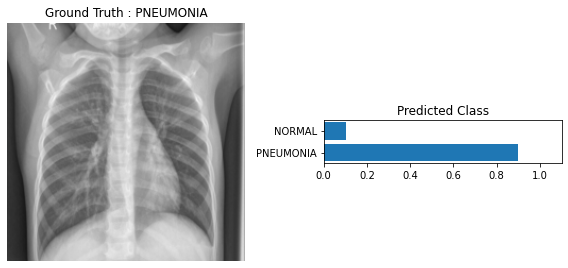

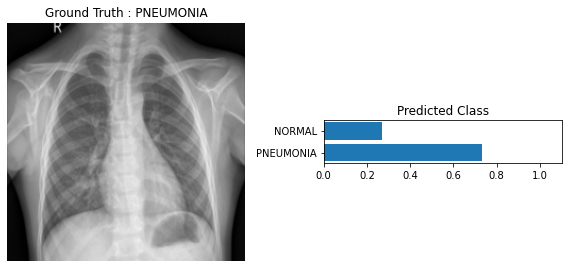

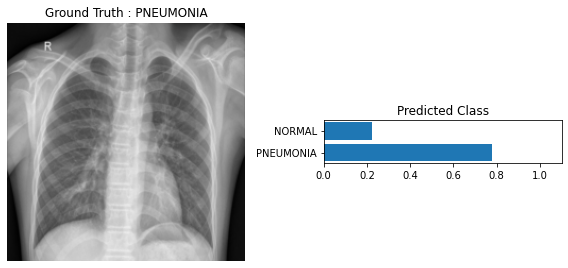

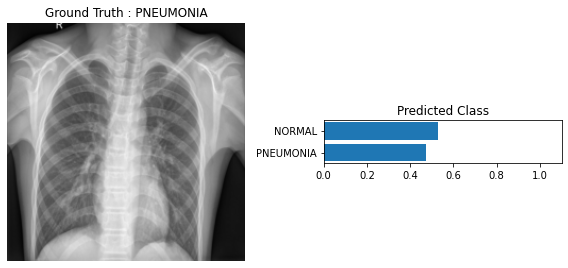

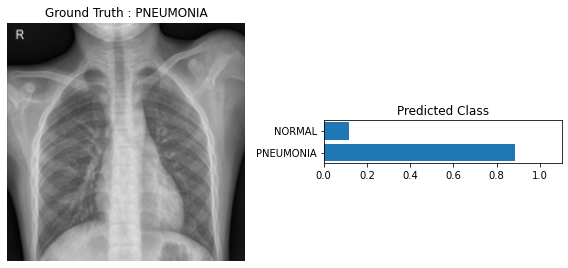

In [142]:
for i in range(10): #show 10 view_classify

    images , labels = testset[i]
    logits = model(images.to(device).unsqueeze(0)) # (3,224,224) -> (1,3,224,224) and move image to device 
    ps = F.softmax(logits, dim= 1)
    Utils.view_classify(images, ps, labels)

In [187]:

def show_preds():
    model.eval()
    images, labels = next(iter(test_dataloader))
    print(type(images))
    outputs = model(images.to(device))
    
    _,preds = torch.max(outputs,1)

    print(type(preds))
    preds = preds.squeeze().detach().cpu()
    show_images(images, labels, preds)

<class 'torch.Tensor'>
<class 'torch.Tensor'>


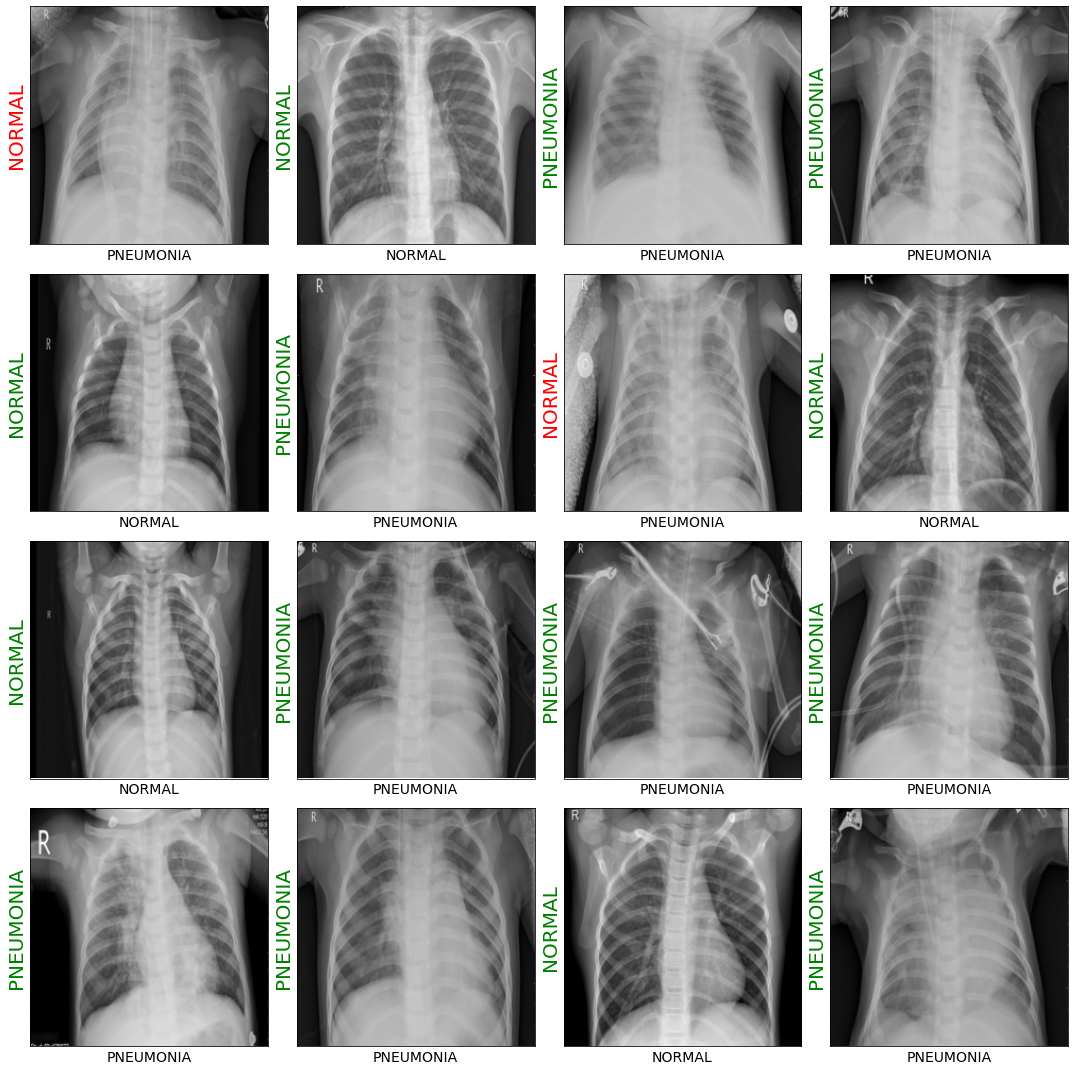

In [188]:
show_preds()